<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [11]:
%run supportvectors-common.ipynb

ModuleNotFoundError: No module named 'sklearn'

ModuleNotFoundError: No module named 'sklearn'

In [12]:
!pip install sklearn


Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

# BERT embeddings

In this example, we demonstrate the typical anisotropy exhibited by a standard bert based model using the following approach: 
- Generate the embeddings created by the model on chunks of text across three different subjects - Physics, Biology, History.  
- PCA based 2-dimensional projection to bring down the high-dimensional vectors to 2-dimensions
- Visualize the 2-dimensional embeddings in a matplotlib to show how they all fall within a narrow angle on the plane.

**Model: `google-bert/bert-base-uncased`**

In [2]:
import torch
from sentence_transformers import SentenceTransformer
from embedding_basics import config

Some utility functions for working with our custom dataset of subject chunks to bring them to hugging-face dataset format, and to be able to run evaluations on test data to evaluate the model performance.

In [3]:
from embedding_basics.hf_text_utils import get_train_test_lists
# Get the base huggingface model
model_name = "google-bert/bert-base-uncased"

In [4]:
# Retrieve all data labeled with subjects
all_data, _ = get_train_test_lists(cfg=config, split = 1.0)# Extract all sentences from the data
all_data = all_data[:1000]
data_sentences = [text for _, text in all_data]
labels = [label for label, _ in all_data]

## Load the Model from HuggingFace (not the preferred approach since it requires model to be loaded locally)

In [5]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = 'cuda' if torch.cuda.is_available() else device

model = SentenceTransformer(model_name).to(device)
# Encode the sentences
embeddings = model.encode(data_sentences)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: google-bert/bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


We now do the following:

- create embeddings of sample text from our subject chunks folder
- use PCA to reduce dimensionality to 2 dimensions
- visualize these embeddings in matplotlib

## Use the below alternate preferred approach

In [5]:
from embedding_basics.sv_ray_cluster_api import embed_text

In [6]:
batch_size = 50  # change as needed
embeddings = embed_text(data_sentences, model_name, batch_size)

Batch 0 to 50 processed successfully
Batch 50 to 100 processed successfully
Batch 100 to 150 processed successfully
Batch 150 to 200 processed successfully
Batch 200 to 250 processed successfully
Batch 250 to 300 processed successfully
Batch 300 to 350 processed successfully
Batch 350 to 400 processed successfully
Batch 400 to 450 processed successfully
Batch 450 to 500 processed successfully
Batch 500 to 550 processed successfully
Batch 550 to 600 processed successfully
Batch 600 to 650 processed successfully
Batch 650 to 700 processed successfully
Batch 700 to 750 processed successfully
Batch 750 to 800 processed successfully
Batch 800 to 850 processed successfully
Batch 850 to 900 processed successfully
Batch 900 to 950 processed successfully
Batch 950 to 1000 processed successfully


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(embeddings)

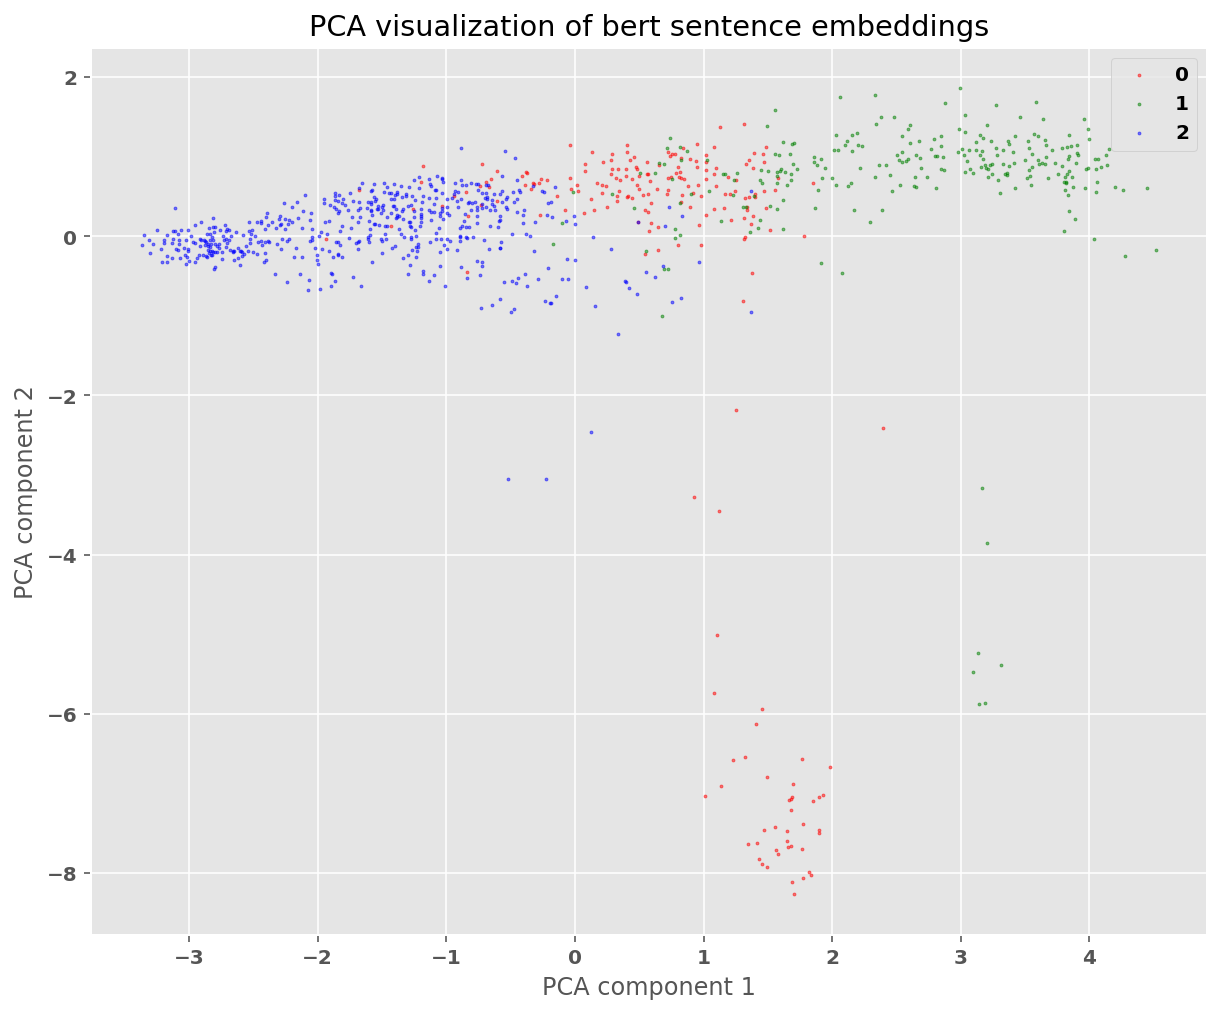

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

# Plot each subject with a different color
unique_labels = list(set(labels))
colors = ['r', 'g', 'b'][:len(unique_labels)]  # Adjust colors based on the number of unique labels

for i, label in enumerate(unique_labels):
    indices = [j for j, label_id in enumerate(labels) if label_id == label]
    plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=2)

plt.title('PCA visualization of bert sentence embeddings')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend()
plt.show()

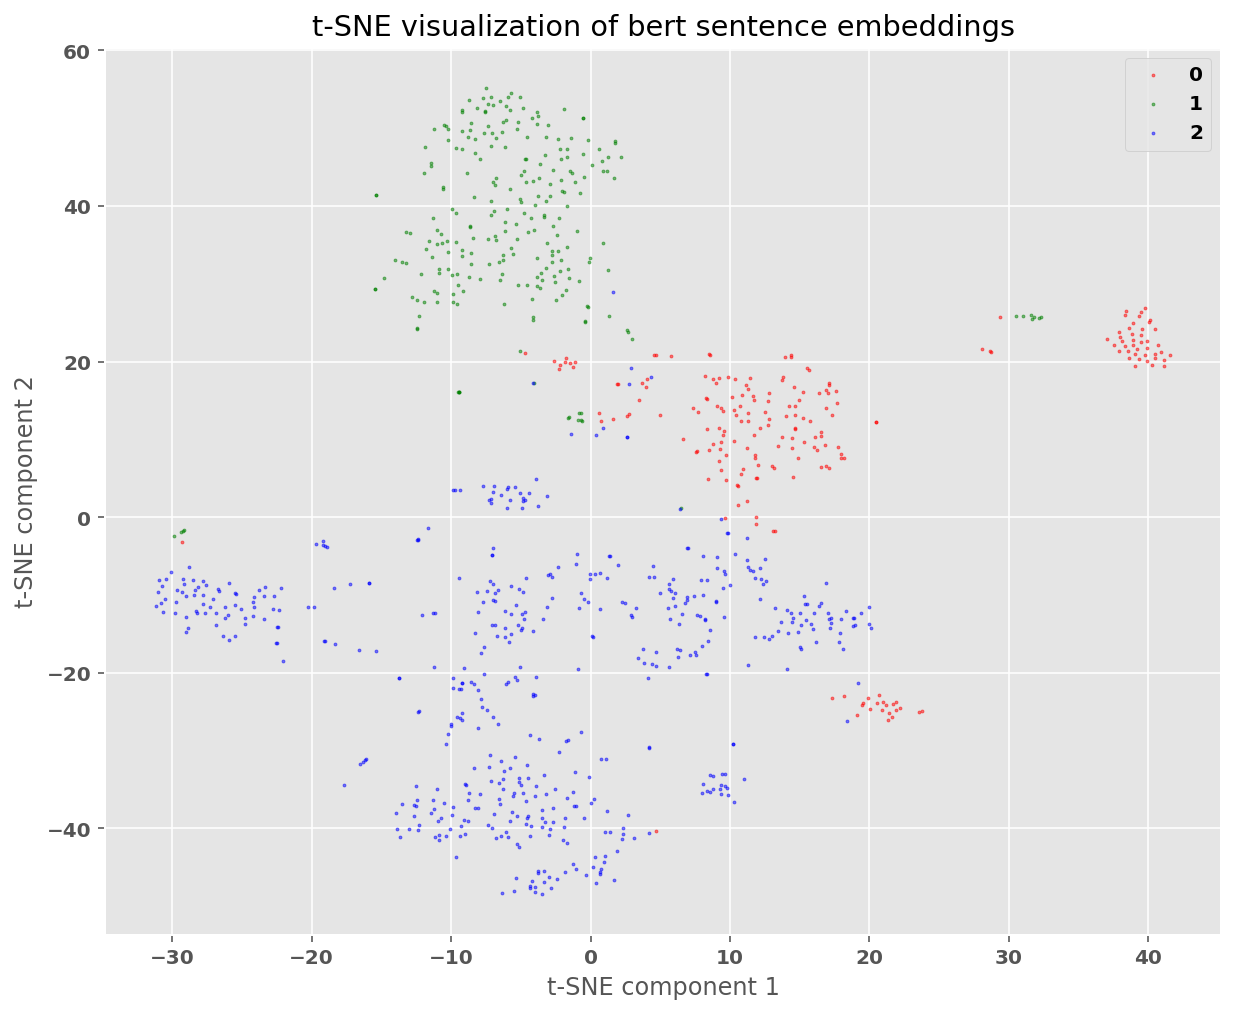

In [9]:
from sklearn.manifold import TSNE
import numpy as np

bert_tsne = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto")
bert_tsne_embeddings = bert_tsne.fit_transform(np.array(embeddings))

plt.figure(figsize=(10, 8))

# Plot each subject with a different color
unique_labels = list(set(labels))
colors = ['r', 'g', 'b'][:len(unique_labels)]  # Adjust colors based on the number of unique labels

for i, label in enumerate(unique_labels):
    indices = [j for j, label_id in enumerate(labels) if label_id == label]
    plt.scatter(bert_tsne_embeddings[indices, 0], bert_tsne_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=2)

plt.title('t-SNE visualization of bert sentence embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()

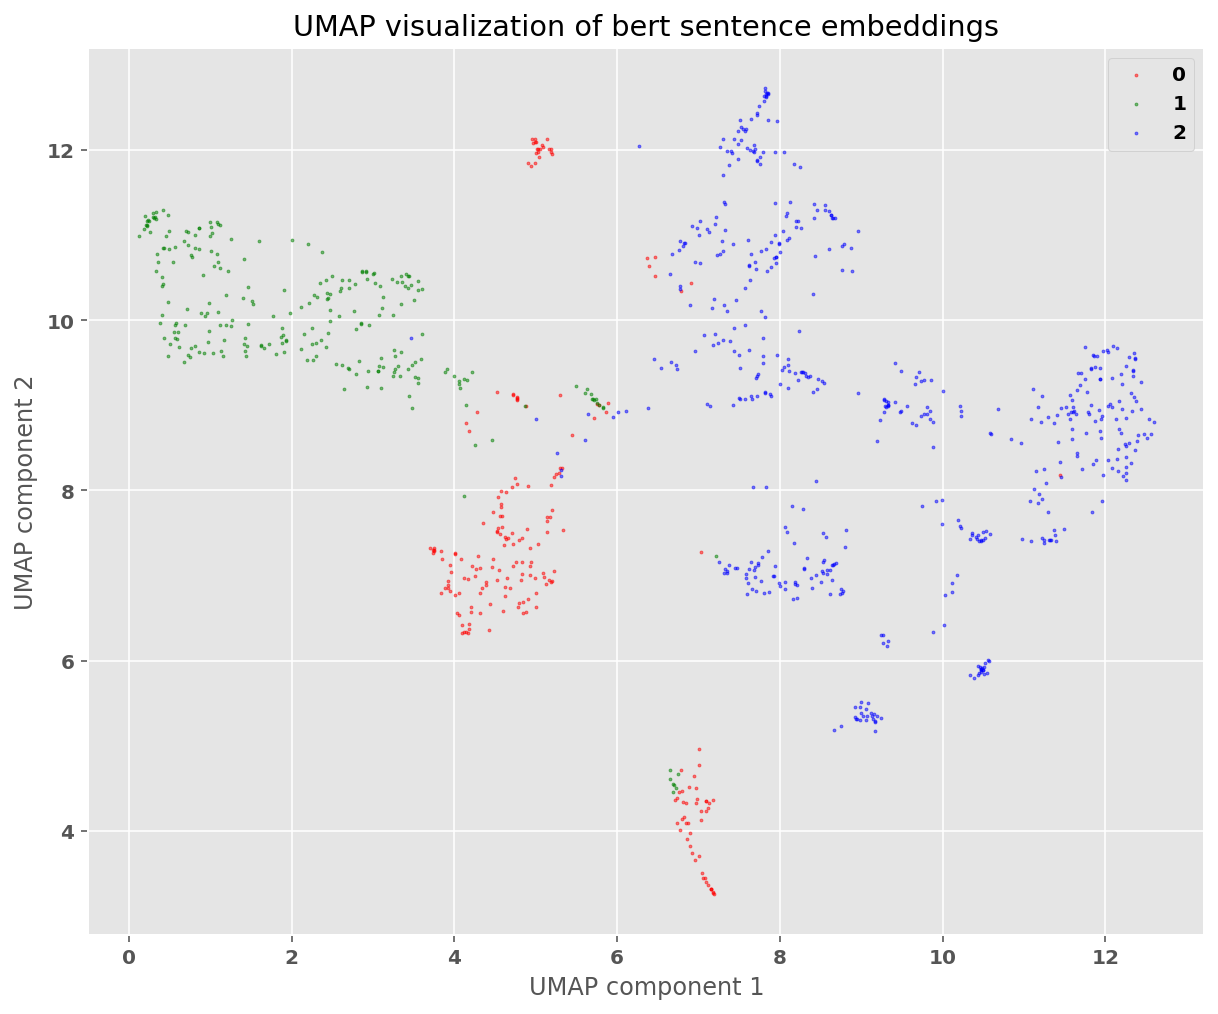

In [10]:
import umap

bert_umap = umap.UMAP(n_components=2, random_state=42)
bert_umap_embeddings = bert_umap.fit_transform(embeddings)

plt.figure(figsize=(10, 8))

# Plot each subject with a different color
unique_labels = list(set(labels))
colors = ['r', 'g', 'b'][:len(unique_labels)]  # Adjust colors based on the number of unique labels

for i, label in enumerate(unique_labels):
    indices = [j for j, label_id in enumerate(labels) if label_id == label]
    plt.scatter(bert_umap_embeddings[indices, 0], bert_umap_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=2)

plt.title('UMAP visualization of bert sentence embeddings')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.legend()
plt.show()

We notice that most of the points are within a small angular spread on the 2-d plane.  This shows the inherent problem with the BERT based embeddings that exhibit a stark anisotropy.  

## Sentence Transformer Embeddings

Now, we repeat the same for a sentence transformer model **BAAI/bge-base-en-v1.5**, that has been trained on contrastive loss

In [11]:
sbert_model_name = 'BAAI/bge-base-en-v1.5'

## Avoid below approach and instead use the API

In [13]:
sbert_model = SentenceTransformer(sbert_model_name).to(device)
sbert_embeddings = sbert_model.encode(data_sentences)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## Alternate preferred API approach

In [12]:
batch_size = 50  # change as needed
sbert_embeddings = embed_text(data_sentences, sbert_model_name, batch_size)

Batch 0 to 50 processed successfully
Batch 50 to 100 processed successfully
Batch 100 to 150 processed successfully
Batch 150 to 200 processed successfully
Batch 200 to 250 processed successfully
Batch 250 to 300 processed successfully
Batch 300 to 350 processed successfully
Batch 350 to 400 processed successfully
Batch 400 to 450 processed successfully
Batch 450 to 500 processed successfully
Batch 500 to 550 processed successfully
Batch 550 to 600 processed successfully
Batch 600 to 650 processed successfully
Batch 650 to 700 processed successfully
Batch 700 to 750 processed successfully
Batch 750 to 800 processed successfully
Batch 800 to 850 processed successfully
Batch 850 to 900 processed successfully
Batch 900 to 950 processed successfully
Batch 950 to 1000 processed successfully


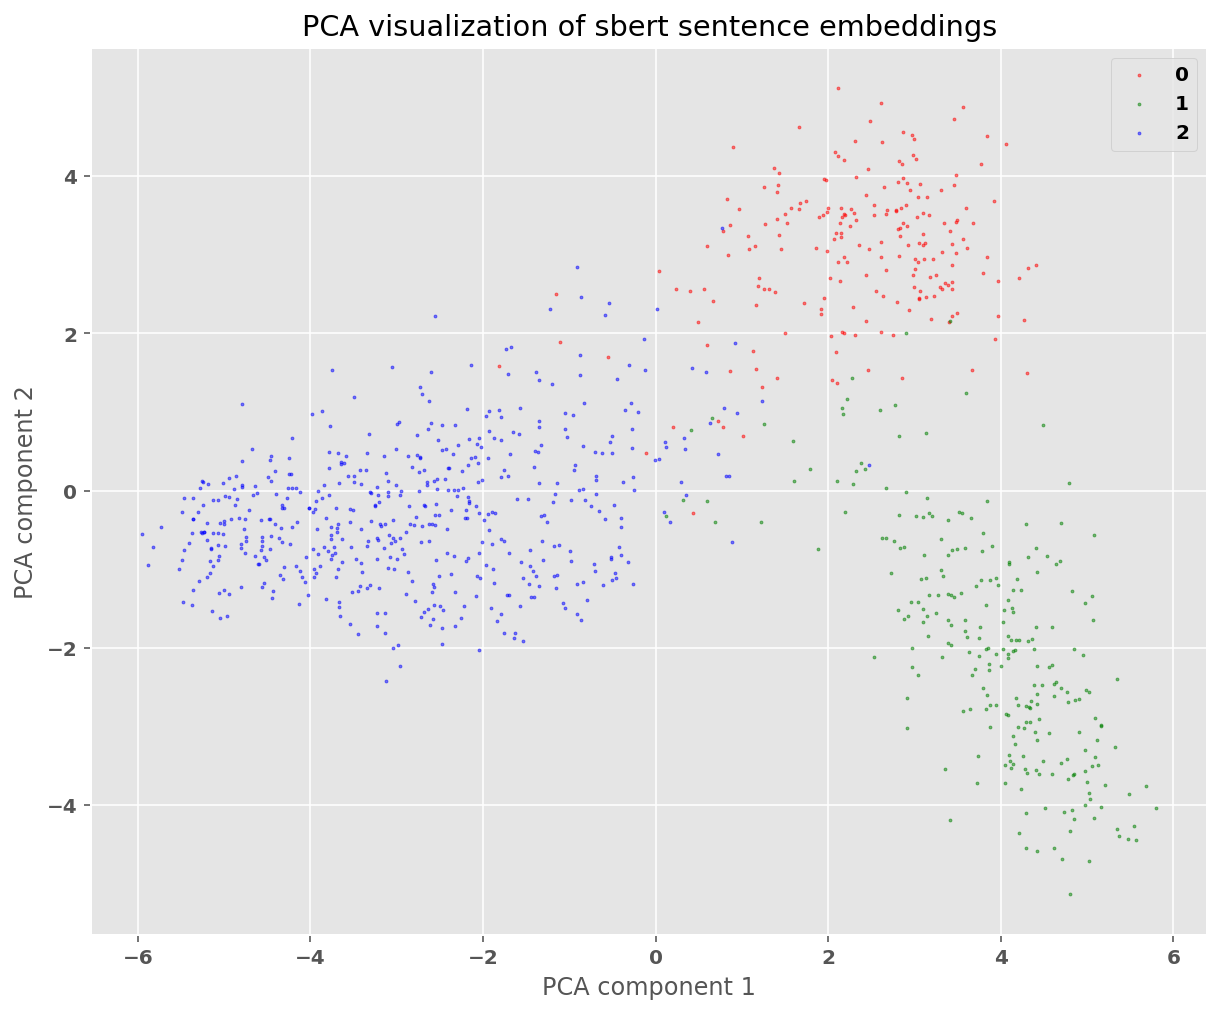

In [13]:
sbert_pca = PCA(n_components=2, random_state=42)
sbert_pca_embeddings = sbert_pca.fit_transform(sbert_embeddings)
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    indices = [j for j, label_id in enumerate(labels) if label_id == label]
    plt.scatter(sbert_pca_embeddings[indices, 0], sbert_pca_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=2)

plt.title('PCA visualization of sbert sentence embeddings')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend()
plt.show()


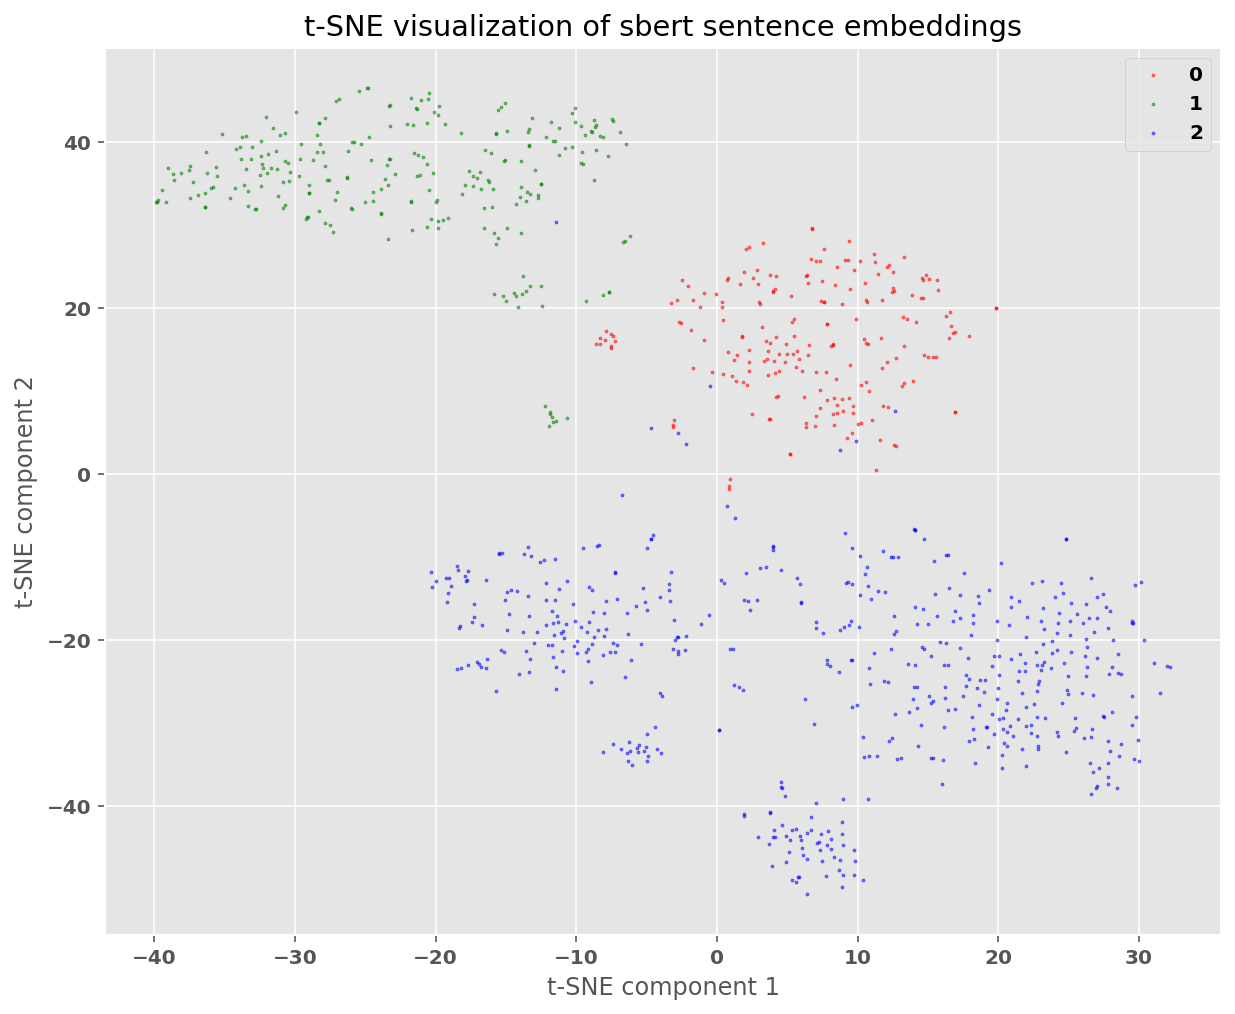

In [14]:
from sklearn.manifold import TSNE
import numpy as np

sbert_tsne = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto")
sbert_tsne_embeddings = sbert_tsne.fit_transform(np.array(sbert_embeddings))

plt.figure(figsize=(10, 8))

# Plot each subject with a different color
unique_labels = list(set(labels))
colors = ['r', 'g', 'b'][:len(unique_labels)]  # Adjust colors based on the number of unique labels

for i, label in enumerate(unique_labels):
    indices = [j for j, label_id in enumerate(labels) if label_id == label]
    plt.scatter(sbert_tsne_embeddings[indices, 0], sbert_tsne_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=2)

plt.title('t-SNE visualization of sbert sentence embeddings')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()

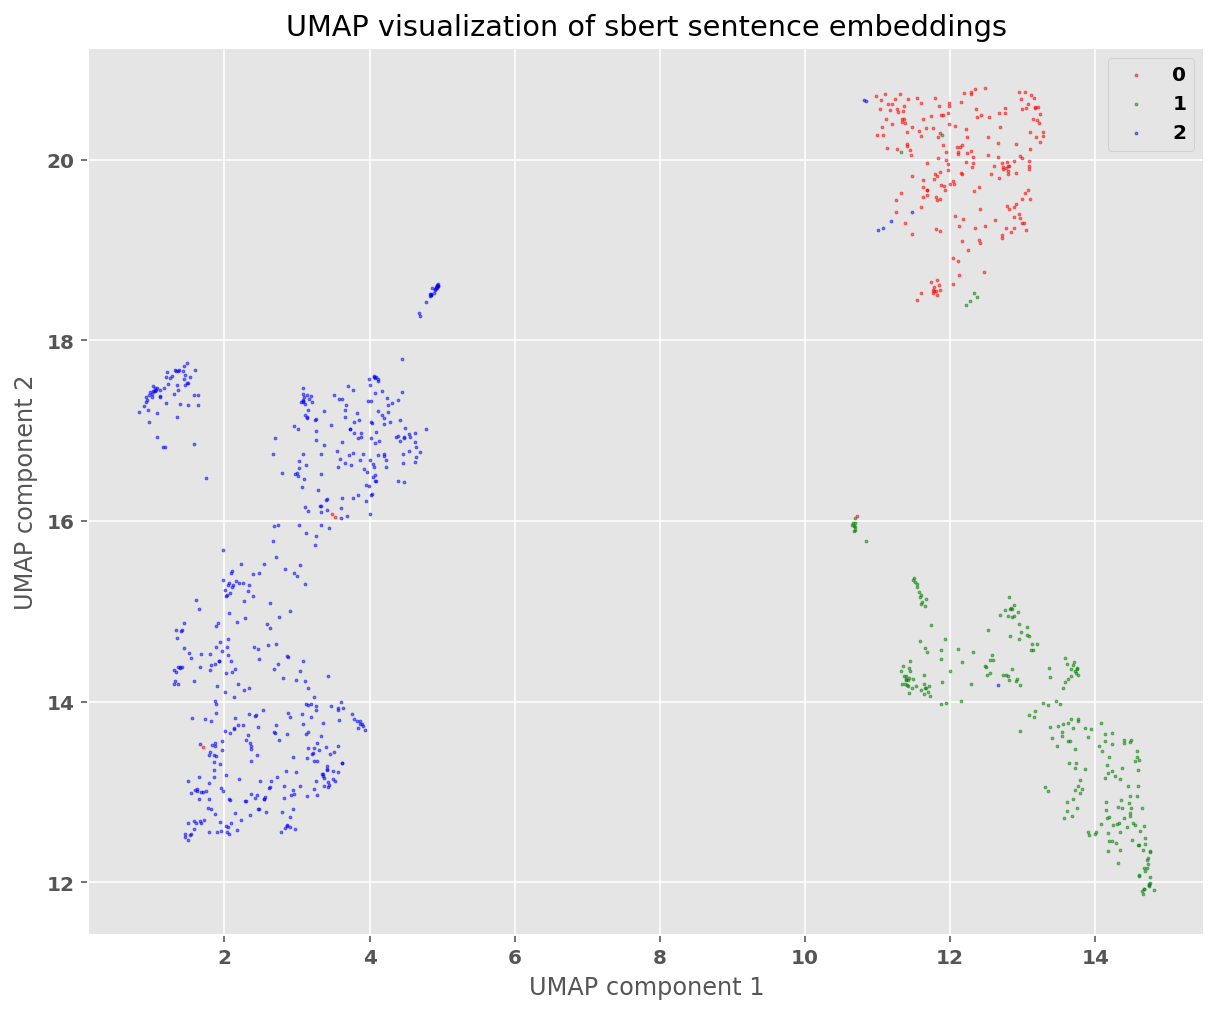

In [15]:
import umap

sbert_umap = umap.UMAP(n_components=2, random_state=42)
sbert_umap_embeddings = sbert_umap.fit_transform(sbert_embeddings)

plt.figure(figsize=(10, 8))

# Plot each subject with a different color
unique_labels = list(set(labels))
colors = ['r', 'g', 'b'][:len(unique_labels)]  # Adjust colors based on the number of unique labels

for i, label in enumerate(unique_labels):
    indices = [j for j, label_id in enumerate(labels) if label_id == label]
    plt.scatter(sbert_umap_embeddings[indices, 0], sbert_umap_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=2)

plt.title('UMAP visualization of sbert sentence embeddings')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.legend()
plt.show()